In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import eigvals
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances


In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to range [0,1]
train_images = train_images.astype('float32')/255.

In [ ]:
# Load MobileNet model
mobilenet = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
                   input_shape=(224, 224, 3),
                   trainable=False),
])

In [ ]:
batch_trainig = 1000

In [ ]:
# Resize images to 224x224 (required input size for MobileNet)
resized_images = tf.image.resize(train_images[0:batch_trainig,:], (224, 224))
# Extract deep features for the resized images
train_features = mobilenet.predict(resized_images)

32/32 [==============================] - 1s 30ms/step


In [ ]:
# Create PCA object with components
pca = PCA(n_components=224)

# Fit PCA to the training features
pca.fit(train_features)

# Transform the training and test features using the fitted PCA
train_features_pca = pca.transform(train_features)

In [ ]:
def plot(X,labels):
  # Visualize in 2D using t-SNE
  tsne = TSNE(n_components=2 ,random_state=42)
  X_tsne = tsne.fit_transform(X)
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
  plt.show()

  # Visualize in 3D using t-SNE
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  tsne = TSNE(n_components=3, random_state=42)
  X_tsne = tsne.fit_transform(X)
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels)
  plt.show()

In [ ]:
def kmeans(X, k, max_iterations=100):
    # Initialize centroids randomly
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for i in range(max_iterations):
        # Compute distances between each data point and the centroids
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))

        # Assign each data point to the closest centroid
        labels = np.argmin(distances, axis=0)

        # Update centroids based on the mean of the data points assigned to each centroid
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check if the centroids have converged
        if np.allclose(new_centroids, centroids):
            break

        centroids = new_centroids

    return labels, centroids


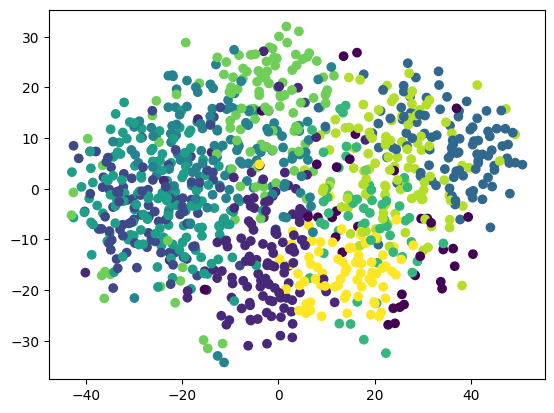

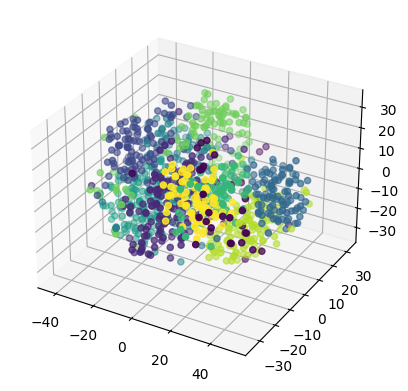

In [ ]:
y_hat,centroid = kmeans(train_features_pca,10)
plot(train_features_pca ,y_hat)

In [ ]:
def spectral_clustering(X, k, sigma=1):
    # Construct similarity matrix
    n = X.shape[0]
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(X[i] - X[j])
            W[i][j] = np.exp(-dist**2/(2*sigma**2))
            W[j][i] = W[i][j]

    # Compute degree matrix
    D = np.diag(np.sum(W, axis=1))

    # Compute Laplacian matrix
    L = D - W

    # Compute first k eigenvectors of Laplacian matrix
    eigvals, eigvecs = np.linalg.eigh(L)
    U = eigvecs[:, :k]
    # Apply k-means clustering to rows of U
    y_hat,centroid = kmeans(X,10)
    return y_hat

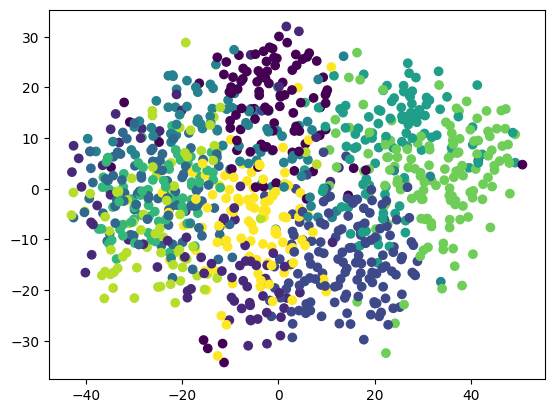

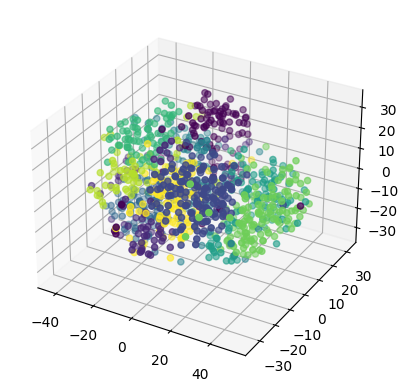

In [ ]:
y_hat = spectral_clustering(train_features,10)
plot(train_features_pca ,y_hat)

In [ ]:
def dbscan(X, eps, min_samples):
    n = X.shape[0]
    labels = np.zeros(n, dtype=int)
    visited = np.zeros(n, dtype=bool)

    # Find core points and assign cluster labels
    cluster_id = 0
    for i in range(n):
        if visited[i]:
            continue

        visited[i] = True
        neighbors = _find_neighbors(X, i, eps)
        if len(neighbors) < min_samples:
            labels[i] = -1 # Noise point
        else:
            cluster_id += 1
            labels[i] = cluster_id
            _expand_cluster(X, i, neighbors, eps, visited, labels, cluster_id, min_samples)

    return labels

def _find_neighbors(X, i, eps):
    neighbors = []
    for j in range(X.shape[0]):
        if i != j and np.linalg.norm(X[i] - X[j]) < eps:
            neighbors.append(j)
    return neighbors

def _expand_cluster(X, i, neighbors, eps, visited, labels, cluster_id, min_samples):
    for j in neighbors:
        if not visited[j]:
            visited[j] = True
            new_neighbors = _find_neighbors(X, j, eps)
            if len(new_neighbors) >= min_samples:
                neighbors.extend(new_neighbors)
        if labels[j] == 0:
            labels[j] = cluster_id


# Example usage
X = train_features_pca
labels = dbscan(X, 20, 10)
print(labels)

[-1 -1 -1  1  2  2  2  1  2 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  2 -1  2  2 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  2  2  2  2
  2 -1 -1 -1 -1 -1  2 -1 -1  1 -1 -1  2  2  2  2 -1  2 -1  2 -1  2 -1 -1
 -1 -1 -1  2  2  2 -1  2 -1 -1 -1 -1 -1 -1  1 -1  2 -1 -1 -1 -1  2  2 -1
  2 -1  1  2 -1 -1 -1 -1 -1  2  2 -1  2  2 -1 -1  2 -1 -1  2 -1 -1  2  2
  2  2  2 -1 -1 -1  2  2 -1  2 -1 -1 -1 -1 -1  2  2  2  2  2 -1 -1  2 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  2  2 -1 -1 -1 -1  2 -1
  2 -1 -1 -1 -1 -1 -1  1  2 -1  1 -1  1 -1  3 -1  2  2 -1 -1  2 -1  2 -1
 -1  2 -1 -1  2 -1  2  2 -1  2 -1 -1 -1 -1  2 -1  2 -1 -1 -1  2  2 -1 -1
 -1 -1  2  2  2  2 -1 -1 -1  2  2 -1 -1 -1 -1 -1 -1  2 -1 -1  2 -1  2 -1
 -1 -1 -1 -1  2 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  2 -1 -1 -1 -1 -1  2  2  2
  2 -1 -1 -1 -1  2 -1  2 -1  2  2  2  2 -1  2 -1  2 -1 -1  1 -1 -1  1 -1
 -1  1  2 -1 -1 -1 -1  2 -1 -1 -1  1 -1 -1  2  2  2 -1  2 -1 -1  2 -1  2
  2 -1 -1 -1  2  2 -1 -1 -1 -1  2  2 -1  2 -1 -1  2

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=20, min_samples=10).fit(train_features)
clustering.labels_

array([-1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0, -1, -1,
       -1,  1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        0,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1

In [ ]:
def gaussian_kernel(distance, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth)) ** 2)


def mean_shift(X, bandwidth):
    # Initialize centroids to data points
    centroids = X.copy()
    n_samples = X.shape[0]

    # Loop until convergence
    while True:
        distances = pairwise_distances(X, centroids)
        kernel_values = gaussian_kernel(distances, bandwidth)
        weights = kernel_values / np.sum(kernel_values, axis=1)[:, np.newaxis]
        new_centroids = np.dot(weights, X)
        if np.allclose(new_centroids, centroids, rtol=1e-4):
            break
        centroids = new_centroids

    # Assign labels to data points
    labels = np.zeros(n_samples, dtype='int')
    distances = pairwise_distances(X, centroids)
    for i in range(n_samples):
        labels[i] = np.argmin(distances[i])

    return labels


In [ ]:
y_hat = mean_shift(train_features_pca,6)
plot(train_features_pca ,y_hat)

array([589,   5, 147, 167,   5, 427, 103, 167, 504, 589, 167, 632, 632,
       504,   5, 504,   5, 167, 504,   5, 504,   5, 167, 103, 589, 589,
       327, 589, 167, 504,   5,  32,   5, 589, 167,   5, 589, 589, 589,
       167, 167, 504, 632, 167,   5,   5,   5, 504, 504, 504,   5, 589,
       632,   5, 504, 589, 589, 589, 589, 504,   5,   5, 109, 504,   5,
       147, 632,   5, 167, 504, 589,   5, 167, 147, 589,   5, 147, 504,
       589,   5, 504, 589, 167, 589, 589, 589, 167, 632,   5, 589, 589,
       167,   5,   5,   5, 103,   5,  97, 167,   5, 504, 504,   5, 103,
       103,   5, 109, 632, 504,   5, 147, 147,   5, 589, 167, 504, 504,
       167, 147,   5, 504, 504, 147, 504, 167, 167,   5,   5, 589, 504,
       167, 167, 589, 632,   5, 504,   5,   5, 504, 504,   5, 167, 103,
       589, 103, 167, 589,   5, 589, 632, 504,   5, 167, 167, 167, 504,
       589, 993, 167, 589,   5, 504, 993, 167, 167,   5,   5, 167, 147,
       167,   5, 589, 504, 167, 589, 632,   5, 589, 632, 504, 16

In [ ]:
from sklearn.cluster import MeanShift
clustering = MeanShift(bandwidth=6).fit(train_features_pca)
clustering.labels_

array([916,  85, 261, 794,  28, 164, 604, 837, 301, 707, 934, 467, 780,
       347,  81, 139, 134, 722, 785, 341, 565, 555, 908, 939, 768, 789,
       788, 880, 710, 362, 350, 229,   0, 901, 866, 365, 454, 898, 284,
       782, 660, 516, 559, 612, 194, 208,  43, 415, 512, 333, 313, 475,
       895, 171, 676, 527, 759, 640, 882, 258,  30,  61, 255, 583, 152,
        88, 739, 195, 489, 325, 651, 251, 931, 296, 724, 187,  15, 496,
       567, 105, 406, 692, 896, 482, 909, 808, 892, 602, 129, 412, 949,
       657, 396,   5, 130, 579,  25, 202, 821, 228, 267, 835, 203, 799,
       642,  33, 179, 698, 713,   1, 176, 226,   9, 571, 683, 242, 576,
       975, 199,  26, 836, 541, 201, 906, 999, 849,  74, 144, 533, 416,
       929, 584, 883, 444, 268, 312,  96, 116, 574, 274, 295, 998, 855,
       926, 411, 776, 287,  37, 522, 969, 671, 609, 556, 872, 919, 115,
       834, 627, 626, 684, 192, 248, 515, 790, 976, 260, 159, 981,  19,
       822, 294, 389, 337, 741, 531, 760,  80, 623, 681, 461, 84

In [ ]:
from sklearn.decomposition import MiniBatchDictionaryLearning
def subspace_clustering(X, n_clusters):
    # Initialize a dictionary using sparse coding
    dico = MiniBatchDictionaryLearning(n_components=n_clusters, batch_size=10, alpha=1,max_iter=1000)
    D = dico.fit(X).components_

    # Apply K-means clustering on the coefficients matrix
    Z = dico.transform(X)
    labels,centroids = kmeans(Z,n_clusters)

    return labels


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


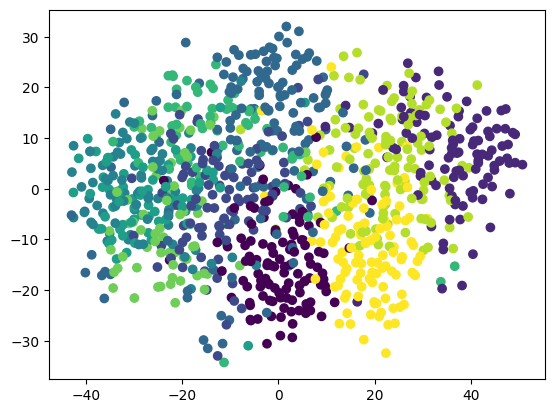

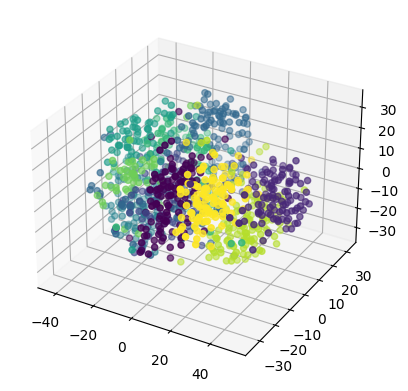

In [ ]:
y_hat = subspace_clustering(train_features_pca,10)
plot(train_features_pca,y_hat)